### CNN. Классификация текста

In [1]:
import torch

# torchtext багается, так что датасет загрузим из hugging-face
%pip install datasets -q
from datasets import load_dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import re

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

from gensim.models import Word2Vec

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F

import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


/home/dalabaya/anaconda3/envs/ml-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalabaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dalabaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dalabayabilay (dalabayabilay-kazakh-british-technical-university). Use `wandb login --relogin` to force relogin


True

In [2]:
assert torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
imdb_dataset = load_dataset("imdb")

train_data = imdb_dataset['train']
test_data = imdb_dataset['test']

In [4]:
train_data['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

### Построим baseline на tf-idf с логрегом

In [5]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1, 4))

tfidf_vectorizer.fit(train_data['text'])

TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 4))

In [6]:
train_vectors = tfidf_vectorizer.transform(train_data['text'])
test_vectors = tfidf_vectorizer.transform(test_data['text'])

train_labels = train_data['label']
test_labels = test_data['label']

In [7]:
def train_eval_logreg(
    train_vectors, 
    test_vectors, 
    train_labels, 
    test_labels
):
    logreg_model = LogisticRegression(max_iter=500)
    logreg_model.fit(train_vectors, train_labels)

    train_predictions = logreg_model.predict(train_vectors)
    test_predictions = logreg_model.predict(test_vectors)

    train_acc = accuracy_score(train_labels, train_predictions)
    test_acc = accuracy_score(test_labels, test_predictions)

    print("Train accuracy: ", round(train_acc, 3))
    print("Test accuracy: ", round(test_acc, 3))

In [8]:
train_eval_logreg(
    train_vectors,
    test_vectors,
    train_labels,
    test_labels
)

Train accuracy:  0.956
Test accuracy:  0.892


### Теперь будем делать сверточные сети

в датасете много html тэгов, очистим регуляркой

In [9]:
def tokenize(text):
    reg_exp = re.compile(r'\w+')
    return reg_exp.findall(text)

In [10]:
train_tokens = [tokenize(t.lower()) for t in train_data['text']]
test_tokens = [tokenize(t.lower()) for t in test_data['text']]

In [11]:
stop_words = stopwords.words('english')

In [12]:
def remove_stopwords(tokenized_texts):
    clean_texts = []
    for tokens in tokenized_texts:
        clean_texts.append([token for token in tokens if token not in stop_words])
    return clean_texts

In [13]:
train_tokens = remove_stopwords(train_tokens)
test_tokens = remove_stopwords(test_tokens)

In [14]:
def lemmatize_text(tokenized_texts):
    lemmatized_texts = []
    lemmatizer = WordNetLemmatizer()
    for words in tqdm(tokenized_texts):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_texts.append(lemmatized_words)
    return lemmatized_texts

In [15]:
train_lemmas = lemmatize_text(train_tokens)
test_lemmas = lemmatize_text(test_tokens)

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:07<00:00, 3515.96it/s]


In [16]:
w2v_model = Word2Vec(
    train_lemmas,
    vector_size=100,
    min_count=4,
    window=5
).wv

In [17]:
def encode_dataset(dataset):
    encoded = []
    for words in dataset:
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))
    return encoded

In [18]:
train_embeddings = encode_dataset(train_lemmas)
test_embeddings = encode_dataset(test_lemmas)

Text(0, 0.5, 'Количество')

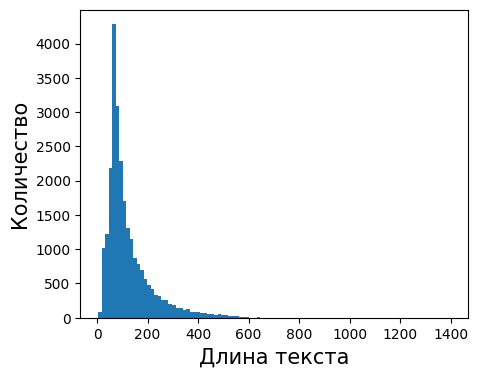

In [19]:
text_lengths = [len(x) for x in train_embeddings]

plt.figure(figsize=(5, 4))
plt.hist(text_lengths, bins=100)
plt.xlabel('Длина текста', size=15)
plt.ylabel('Количество', size=15)


In [20]:
not_truncated = sum([1 if len(x) <= 512 else 0 for x in train_embeddings])

print(f"Not truncated in 512 input size percentage: {round(not_truncated / len(train_embeddings), 3)}")

Not truncated in 512 input size percentage: 0.994


### Создание датасета из эмбеддингов

In [21]:
train_dataset = list(zip(train_embeddings, train_labels))
test_dataset = list(zip(test_embeddings, test_labels))

Функция `collate_fn` вызывается внутри `DataLoader` для батча данных. Используем ее для дополнения текстов паддингами.

pad_sequence - почему то перемешивает, можно делать permute либо batch_first=True

In [22]:
def collate_fn(batch):
    x, labels = zip(*batch)
    padded_x = pad_sequence(x, batch_first=True)
    return padded_x, torch.Tensor(labels)

In [23]:
w2v_train_loader = DataLoader(
    train_dataset, 
    collate_fn=collate_fn, 
    shuffle=True,
    batch_size=32)

w2v_test_loader = DataLoader(
    test_dataset,
    collate_fn=collate_fn,
    shuffle=False,
    batch_size=8
)

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self, hid_dim=100):
        super().__init__()

        self.conv1 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)

        self.fc = nn.Linear(hid_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, seq_length, embedding_dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        #print("Permute shape: ", x.shape)
        x = self.conv1(x)
        #print("Conv1 shape: ", x.shape)
        x = self.relu(x)
        #print("ReLU1 shape: ", x.shape)
        x = self.conv2(x)
        #print("Conv2 shape: ", x.shape)
        x = self.relu(x)
        #print("ReLU2 shape: ", x.shape)

        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)

        #print("Max Pool shape: ", x.shape)

        x = self.fc(x)

        #print("Full connected shape: ", x.shape)

        x = x.squeeze(dim=1)

        return x

In [26]:
def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """
    # не забываем переводить в train режим
    model.train()
    criterion = nn.BCEWithLogitsLoss()

    training_logs = []

    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = (logits > 0).long()
        current_res = {
            'train_loss' : loss.item(),
            'train_accuracy' : (preds == labels).float().mean().item()
        }

        wandb.log(current_res)

    return training_logs

In [27]:
@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Тестирует модель (model) на всем наборе данных (dataloader).
    """
    # не забываем переводить в eval режим
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    correct = []
    losses = []
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        preds = (logits > 0).long()
        correct.extend((preds == labels).float().cpu())
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)

    current_res = {
        'test_loss' : mean_loss,
        'test_accuracy' : accuracy
    }

    wandb.log(current_res)

    return accuracy, mean_loss


In [28]:
model = SimpleCNN()

model = model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-3
)

In [29]:
wandb.init(project="nlp_lesson2", name="simple_cnn_BCEloss")

In [30]:
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

test_accuracy,▁▅▆▇█
test_loss,█▄▃▂▁
train_accuracy,▁▃▃▆▆▆▆▆▆▄▅▇▄▆▆▇▆█▇▆▇▇▇▆▇▆█▇▇█▅▅▆▆▇▅▇▅▇▅
train_loss,█▇█▄▇▅▆▄▆▃▄▄▄▃▆▄▃▄▄▅▄▆▄▂▃▃▃▄▄▁▅▅▅▂▄▄▁▄▂▃
test_accuracy,0.84968
test_loss,0.34723
train_accuracy,0.625
train_loss,0.60284
